## Correção de pose para reconhecimento facial
---
Corrigir a pose das celebridades nas fotografias usando IA Generativa. O objetivo é detectar os olhos e normalizar as imagens geometricamente a partir dos olhos.

*Integrantes*:
- Júlia Moraes
- Luiz Eduardo
- Humberto Nunes
- Pedro Miguel Cecato
- Pedro Lucas Simões

### 1. Primeiros passos
---
Primeiro passo é criar os imports das bibliotecas necessárias e criar as funções básicas de manipulação de imagem, sendo elas uma função para ler a imagem, uma para salvar a imagem e outra para exibir a imagem.

In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from IPython.display import display
from typing import Optional, Tuple
import mediapipe as mp
import math
from scipy.ndimage import median_filter

In [2]:
def ler_imagem(image_path: str):
    # Verifica se o arquivo existe
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Arquivo não encontrado: {image_path}")
    
    # Tenta ler com OpenCV
    image = cv2.imread(image_path)
    
    # Se não conseguiu ler com OpenCV (image=None)
    if image is None:
        try:
            # Tenta ler com Pillow
            with Image.open(image_path) as img_pil:
                image = np.array(img_pil.convert("RGB"))  # converte para RGB
                # OpenCV usa BGR, então convertemos para manter compatibilidade
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        except Exception as e:
            raise ValueError(
                f"Não foi possível ler a imagem nem com OpenCV nem com Pillow: {image_path}\n"
                f"Erro original: {e}"
            )

    return image

def mostrar_imagem(image_path: str):
    # Lê a imagem com OpenCV
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Não foi possível ler a imagem: {image_path}")

    # Converte de BGR (OpenCV) para RGB (PIL)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(image_rgb)
    display(pil_img)

def mostrar_imagem_array(image):
    # Converte de BGR para RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(image_rgb)
    display(pil_img)

def salvar_imagem(image: cv2.Mat, output_path: str, create_dirs: bool = True):
    if image is None or image.size == 0:
        raise ValueError("Imagem inválida ou vazia")
    
    # Verifica se o caminho de saída é válido
    if not output_path:
        raise ValueError("Caminho de saída não especificado")
    
    # Cria diretórios se necessário
    if create_dirs:
        output_dir = os.path.dirname(output_path)
        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir, exist_ok=True)
    
    # Salva a imagem
    success = cv2.imwrite(output_path, image)
    
    if not success:
        raise ValueError(f"Falha ao salvar imagem: {output_path}")
    
    return success

In [5]:
#image_dir = r"G:\Meu Drive\AgeDB_BW"
image_dir = r"G:\.shortcut-targets-by-id\1ES2m5Iu-L1rk_r2BJevBmq9wRwn8QWuZ\AgeDB_BW"
"G:\Meu Drive\AgeDB_BW.lnk"
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))] # tamanho de 14625

imagens = []  # Lista para armazenar as imagens

for img_name in image_files[:10]:
    image_path = os.path.join(image_dir, img_name)
    image = ler_imagem(image_path)
    imagens.append(image)  

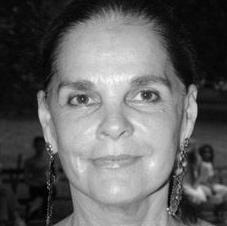

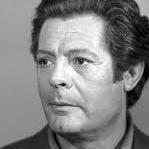

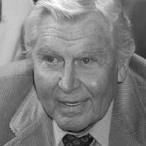

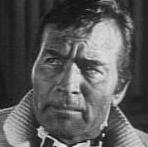

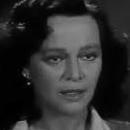

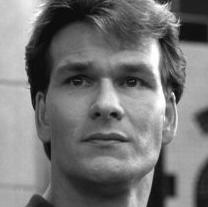

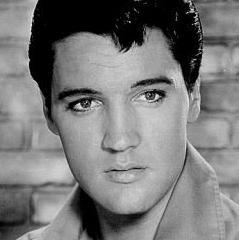

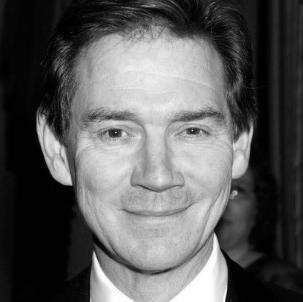

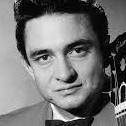

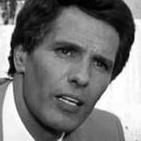

In [6]:
for img in imagens:
    mostrar_imagem_array(img)

### 2.Detecção dos olhos
---
Para fazer a detecção do rosto e dos olhos testamos usar o OpenCV com o Haar Cascades e o MediaPipe

#### 2.1 Haar Cascades
---
Vamos inciar carregando os detectores e exemplificar a função para a deteccção em um array com 10 imagens.

In [7]:
# Detecta faces frontais
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
# Detecta olhos dentro da região do rosto
eye_cascade  = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")

In [8]:
def marcar_olhos_haar(imagens):
    imagens_marcadas = []

    for img in imagens:
        img_copy = img.copy()
        gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY) # converte para escala de cinza
        faces = face_cascade.detectMultiScale(
            gray,
            scaleFactor=1.1, #indica quanto a imagem é reduzida em cada escala
            minNeighbors=5,  #número de vizinhos para validar detecção
            minSize=(25, 25)  #tamanho mínimo do rosto a ser detectado
            )

        # Detecção de olhos dentro da região do rosto
        for (x, y, w, h) in faces:
            roi_gray = gray[y:y+h, x:x+w] #região do rosto

             #aplica a detecção dos olhos no rosto
            eyes = eye_cascade.detectMultiScale(roi_gray, scaleFactor=1.1, minNeighbors=5, minSize=(15,15)) 
            # desenha um círculo no centro do olho
            for (ex, ey, ew, eh) in eyes:
                eye_center = (x + ex + ew//2, y + ey + eh//2)
                cv2.circle(img_copy, eye_center, 2, (0,255,0), -1)
        imagens_marcadas.append(img_copy)
    return imagens_marcadas

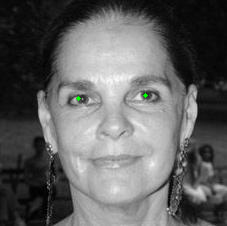

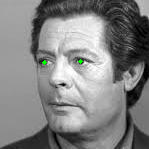

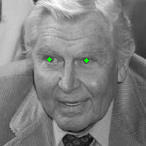

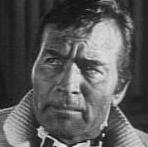

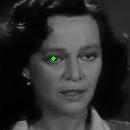

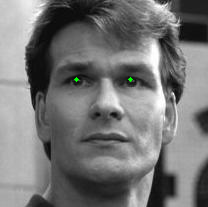

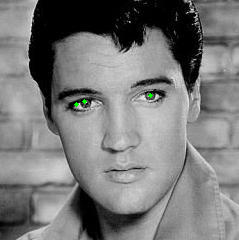

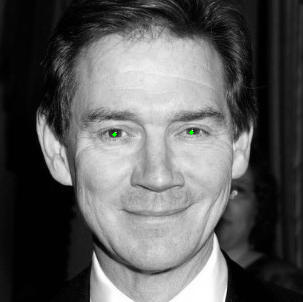

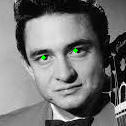

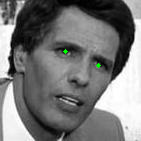

In [9]:
imagens_marcadas = marcar_olhos_haar(imagens)

for i in range(len(imagens_marcadas)):
    mostrar_imagem_array(imagens_marcadas[i])

#### 2.2 MediaPipe

In [10]:
def detectar_olhos(imagens,margem=40):
    
    # Criar objetos do MediaPipe
    mp_face_mesh = mp.solutions.face_mesh  # módulo para malha facial (Face Mesh)
    mp_drawing = mp.solutions.drawing_utils  # utilitário para desenhar pontos/linhas

    # Inicializar o detector de face com algumas configurações
    face_mesh = mp_face_mesh.FaceMesh(
        static_image_mode=True,  # True porque estamos usando imagens fixas (não vídeo)
        max_num_faces=1,         # Detectar apenas 1 face por imagem
        refine_landmarks=True,   # Inclui landmarks detalhados dos olhos/lábios
        min_detection_confidence=0.5  # Confiança mínima para aceitar detecção
    )

    resultados_lista = []  # Aqui vamos guardar os resultados de cada imagem

    # Iterar pelas imagens
    for img in imagens:
        resultado_imagem = {}  # Dicionário para armazenar olhos dessa imagem

        # Converter para RGB (MediaPipe usa RGB, OpenCV usa BGR)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Processar imagem com MediaPipe Face Mesh
        resultado = face_mesh.process(img_rgb)

        if resultado.multi_face_landmarks:  # Se alguma face foi detectada
            face = resultado.multi_face_landmarks[0]  # Pegar a primeira face

            altura, largura, _ = img.shape  # Dimensões da imagem

            # Índices dos landmarks dos olhos no Face Mesh
            # Esquerdo: 33, 133, 160, 159, 158, 153
            # Direito: 362, 263, 387, 386, 385, 380
            olho_esquerdo = []
            olho_direito = []

            for idx in [33, 133, 160, 159, 158, 153]:
                ponto = face.landmark[idx]
                # Converter coordenadas normalizadas (0-1) para pixels
                x, y = int(ponto.x * largura), int(ponto.y * altura)
                olho_esquerdo.append((x, y))

            for idx in [362, 263, 387, 386, 385, 380]:
                ponto = face.landmark[idx]
                x, y = int(ponto.x * largura), int(ponto.y * altura)
                olho_direito.append((x, y))

            # Converter lista de pontos em bounding box
            def criar_caixa(pontos, margem):
                xs = [p[0] for p in pontos]
                ys = [p[1] for p in pontos]
                x_min, x_max = max(min(xs) - margem, 0), min(max(xs) + margem, largura)
                y_min, y_max = max(min(ys) - margem, 0), min(max(ys) + margem, altura)
                return (x_min, y_min, x_max, y_max)

            caixa_esquerda = criar_caixa(olho_esquerdo, margem)
            caixa_direita = criar_caixa(olho_direito, margem)

            # Salvar tanto as listas de pontos quanto as bounding boxes
            resultado_imagem['olho_esquerdo'] = olho_esquerdo  # lista de pontos
            resultado_imagem['olho_direito'] = olho_direito    # lista de pontos
            resultado_imagem['bbox_esquerdo'] = caixa_esquerda  # bounding box
            resultado_imagem['bbox_direito'] = caixa_direita    # bounding box

        resultados_lista.append(resultado_imagem)
    # Retornar a lista com todos os resultados
    return resultados_lista

In [11]:
def desenhar_olhos_mediapipe(imagens, resultados_olhos):
    imagens_marcadas = []
    for img, res in zip(imagens, resultados_olhos):
        img_copy = img.copy()
        # Desenha pontos do olho esquerdo
        if 'olho_esquerdo' in res:
            for (x, y) in res['olho_esquerdo']:
                cv2.circle(img_copy, (x, y), 2, (0,255,0), -1)
        # Desenha pontos do olho direito
        if 'olho_direito' in res:
            for (x, y) in res['olho_direito']:
                cv2.circle(img_copy, (x, y), 2, (0,255,0), -1)
        imagens_marcadas.append(img_copy)
    return imagens_marcadas

In [12]:
def desenhar_centro_olhos_mediapipe(imagens, resultados_olhos):
    imagens_marcadas = []
    for img, res in zip(imagens, resultados_olhos):
        img_copy = img.copy()
        # Olho esquerdo
        if 'olho_esquerdo' in res and len(res['olho_esquerdo']) > 0:
            xs, ys = zip(*res['olho_esquerdo'])
            centro_esq = (int(np.mean(xs)), int(np.mean(ys)))
            cv2.circle(img_copy, centro_esq, 3, (255,0,0), -1)  # azul
        # Olho direito
        if 'olho_direito' in res and len(res['olho_direito']) > 0:
            xs, ys = zip(*res['olho_direito'])
            centro_dir = (int(np.mean(xs)), int(np.mean(ys)))
            cv2.circle(img_copy, centro_dir, 3, (0,0,255), -1)  # vermelho
        imagens_marcadas.append(img_copy)
    return imagens_marcadas

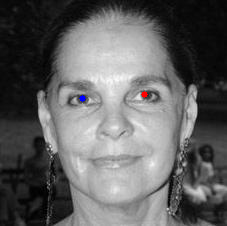

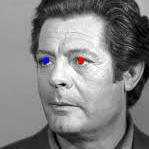

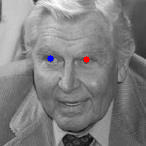

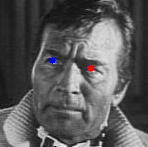

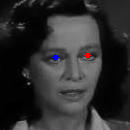

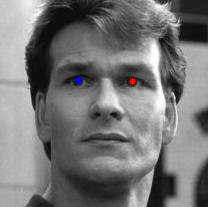

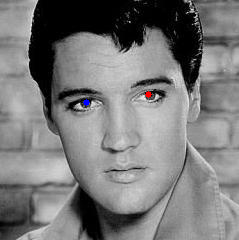

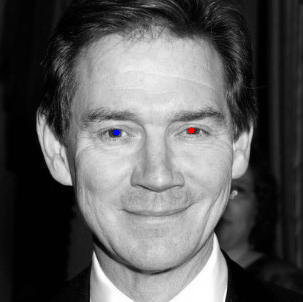

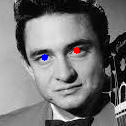

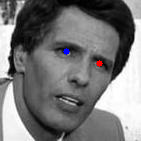

In [15]:
resultados_olhos = detectar_olhos(imagens, margem=40)
imagens_marcadas_mediapipe = desenhar_centro_olhos_mediapipe(imagens, resultados_olhos)

for i in range(len(imagens_marcadas_mediapipe)):
    mostrar_imagem_array(imagens_marcadas_mediapipe[i])

### 3. Ajustes da imagem

#### 3.1 Rotação da imagem 
---
Função para rotacionar as imagens, onde são usados os ângulos entre os olhos, para deixá-las na horizontal, e também colocar os olhos no centro da imagem.

In [21]:
def alinhar_face(img, res):
    if 'bbox_esquerdo' not in res or 'bbox_direito' not in res:
        return img  # nada detectado, retorna original
    
    # Centro dos olhos usando bounding boxes
    # bbox_esquerdo = (x_min, y_min, x_max, y_max)
    bbox_esq = res['bbox_esquerdo']
    bbox_dir = res['bbox_direito']
    
    # Calcular centro de cada bounding box
    centro_esq = ((bbox_esq[0] + bbox_esq[2]) // 2, (bbox_esq[1] + bbox_esq[3]) // 2)
    centro_dir = ((bbox_dir[0] + bbox_dir[2]) // 2, (bbox_dir[1] + bbox_dir[3]) // 2)

    #diferença entre os pontos
    dx = centro_dir[0] - centro_esq[0] # diferença em x
    dy = centro_dir[1] - centro_esq[1] # diferença em y

    #angulo em radianos e depois graus
    angle = math.degrees(math.atan2(dy, dx)) 

    #corrigir sinal → queremos alinhar ao eixo horizontal
    rotation_angle = angle  

    # centro entre os olhos
    eyes_center = ((centro_esq[0] + centro_dir[0]) // 2,
                   (centro_esq[1] + centro_dir[1]) // 2)
    
    # Calcular área necessária para rotação sem cortes
    (h, w) = img.shape[:2]
    
    # Distância dos olhos às bordas da imagem para calcular nova dimensão
    max_dist_x = max(eyes_center[0], w - eyes_center[0])
    max_dist_y = max(eyes_center[1], h - eyes_center[1])
    diagonal = int(math.sqrt(max_dist_x**2 + max_dist_y**2) * 1.5)  # margem extra
    
    # Nova dimensão quadrada para comportar rotação
    new_size = max(diagonal * 2, max(w, h))
    
    # Criar imagem expandida centralizada
    expanded = np.zeros((new_size, new_size, 3), dtype=img.dtype)
    offset_x = (new_size - w) // 2
    offset_y = (new_size - h) // 2
    expanded[offset_y:offset_y+h, offset_x:offset_x+w] = img
    
    # Atualizar posição dos olhos na imagem expandida
    new_eyes_center = (eyes_center[0] + offset_x, eyes_center[1] + offset_y)
    
    # Centro da nova imagem
    center = (new_size // 2, new_size // 2)
    
    # Matriz de rotação
    M = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)
    
    # Translação para levar os olhos ao centro da imagem
    tx = center[0] - new_eyes_center[0]
    ty = center[1] - new_eyes_center[1]
    M[0,2] += tx
    M[1,2] += ty
    
    # Aplicar transformação
    rotated = cv2.warpAffine(expanded, M, (new_size, new_size), borderMode=cv2.BORDER_REFLECT)
    
    # Recortar de volta ao tamanho original (centralizado)
    crop_x = (new_size - w) // 2
    crop_y = (new_size - h) // 2
    result = rotated[crop_y:crop_y+h, crop_x:crop_x+w]

    return result

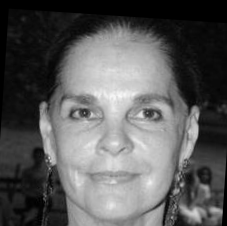

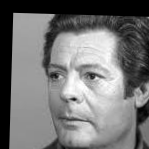

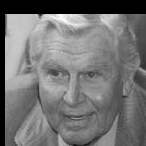

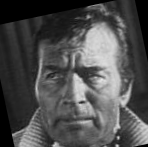

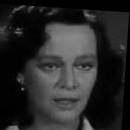

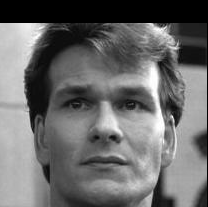

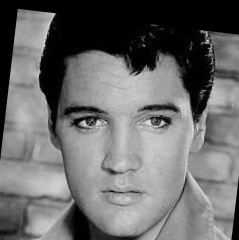

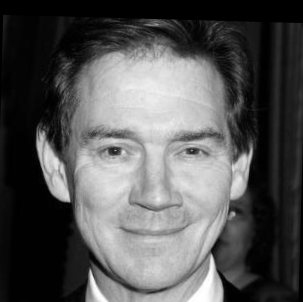

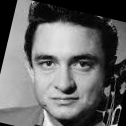

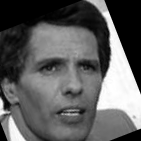

In [22]:
imagens_alinhadas = [alinhar_face(img, res) for img, res in zip(imagens, resultados_olhos)]

for i in range(len(imagens_alinhadas)):
    mostrar_imagem_array(imagens_alinhadas[i])

#### 3.2 Padronização da distância entre os olhos 
---
Padronizar a distância entre os olhos nas imagens utilizando a média coletada pela análise de todas as imagens.  

In [23]:
def media_distancia_olhos(resultados_olhos):
    distancias = []
    for res in resultados_olhos:
        if 'olho_esquerdo' in res and 'olho_direito' in res:
            xs_esq, ys_esq = zip(*res['olho_esquerdo'])
            xs_dir, ys_dir = zip(*res['olho_direito'])
            centro_esq = (np.mean(xs_esq), np.mean(ys_esq))
            centro_dir = (np.mean(xs_dir), np.mean(ys_dir))
            dist = np.linalg.norm(np.array(centro_esq) - np.array(centro_dir))
            distancias.append(dist)
    
    if len(distancias) == 0:
        raise ValueError("Nenhuma distância entre olhos foi detectada.")
    
    return np.mean(distancias), distancias

def padronizar_distancia_olhos(imagens, resultados_olhos):
    
    distancias = []
    for res in resultados_olhos:
        if 'olho_esquerdo' in res and 'olho_direito' in res:

            xs_esq, ys_esq = zip(*res['olho_esquerdo'])
            xs_dir, ys_dir = zip(*res['olho_direito'])
            centro_esq = (np.mean(xs_esq), np.mean(ys_esq))
            centro_dir = (np.mean(xs_dir), np.mean(ys_dir))

            dist = np.linalg.norm(np.array(centro_esq) - np.array(centro_dir))
            distancias.append(dist)

    if len(distancias) == 0:
        raise ValueError("Nenhuma distância entre olhos foi detectada.")
    
    media_distancia = np.mean(distancias)

    # Ajustar cada imagem
    imagens_ajustadas = []
    for img, res in zip(imagens, resultados_olhos):
        if 'olho_esquerdo' not in res or 'olho_direito' not in res:
            imagens_ajustadas.append(img)  # não altera se não detectou olhos
            continue
        
        # Calcular distância atual desta imagem
        xs_esq, ys_esq = zip(*res['olho_esquerdo'])
        xs_dir, ys_dir = zip(*res['olho_direito'])
        centro_esq = (np.mean(xs_esq), np.mean(ys_esq))
        centro_dir = (np.mean(xs_dir), np.mean(ys_dir))
        dist_atual = np.linalg.norm(np.array(centro_esq) - np.array(centro_dir))
        
        # Calcular fator de escala
        escala = media_distancia / dist_atual
        
        # Redimensionar imagem
        h, w = img.shape[:2]
        nova_largura = int(w * escala)
        nova_altura = int(h * escala)
        img_redim = cv2.resize(img, (nova_largura, nova_altura), interpolation=cv2.INTER_LANCZOS4)
        
        imagens_ajustadas.append(img_redim)
    
    return imagens_ajustadas, media_distancia

Média da distância entre olhos: 46.36 pixels


c:\Users\pedro\AppData\Local\Programs\Python\Python39\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


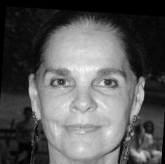

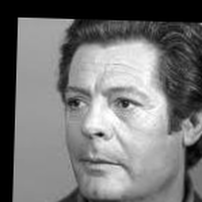

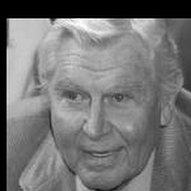

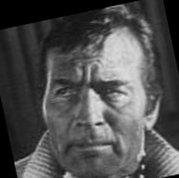

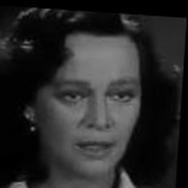

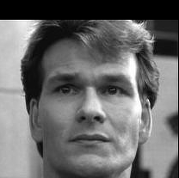

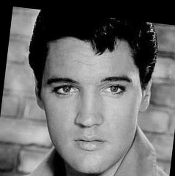

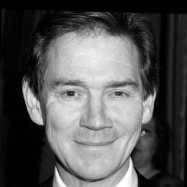

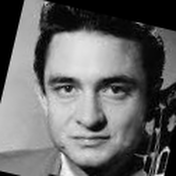

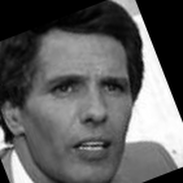

In [24]:
resultados_olhos_alinhados = detectar_olhos(imagens_alinhadas, margem=40)

imagens_padronizadas_olhos, media_distancia_olhos = padronizar_distancia_olhos(imagens_alinhadas, resultados_olhos_alinhados)
print(f"Média da distância entre olhos: {media_distancia_olhos:.2f} pixels")

for i in range(len(imagens_padronizadas_olhos)):
    mostrar_imagem_array(imagens_padronizadas_olhos[i])

#### 3.3 Padronização do tamanho da imagem 
---
Função para padronizar o tamanho das imagens, pegando o valor mais frequente no histograma de altura e largura das imagens do dataset.

In [ ]:
def padronizar_tamanho(imagens, per_centil=90):
    # Lista para armazenar larguras e alturas
    larguras = []
    alturas = []

    # Coletar larguras e alturas de todas as imagens
    for img in imagens:
        h, w = img.shape[:2]
        larguras.append(w)
        alturas.append(h)

    larguras = np.array(larguras)
    alturas = np.array(alturas)

    # Criar histogramas e encontrar o bin (tamanho de imagem) com maior frequência
    hist_w, bins_w = np.histogram(larguras, bins='auto')
    hist_h, bins_h = np.histogram(alturas, bins='auto')

    # Encontrar o bin com o maior número de ocorrências
    max_bin_w = np.argmax(hist_w)
    max_bin_h = np.argmax(hist_h)

    # Definir tamanho representativo como centro do bin mais populoso
    tamanho_w = int((bins_w[max_bin_w] + bins_w[max_bin_w+1]) / 2)
    tamanho_h = int((bins_h[max_bin_h] + bins_h[max_bin_h+1]) / 2)

    imagens_redimensionadas = []

    for img in imagens:
        img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        img_redim = img_pil.resize((tamanho_w, tamanho_h), Image.Resampling.LANCZOS) # Redimensiona a imagem
        img_redim_cv2 = cv2.cvtColor(np.array(img_redim), cv2.COLOR_RGB2BGR)
        imagens_redimensionadas.append(img_redim_cv2)

    return imagens_redimensionadas, (tamanho_w, tamanho_h)

Média do tamanho das imagens: 176x175 pixels


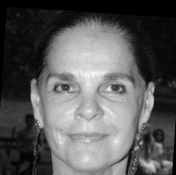

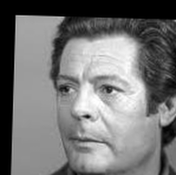

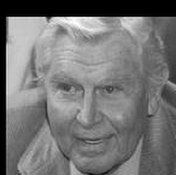

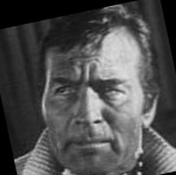

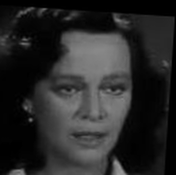

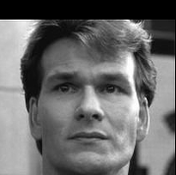

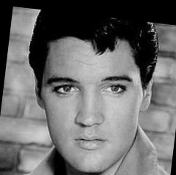

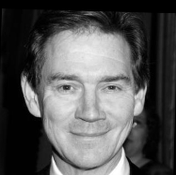

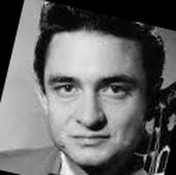

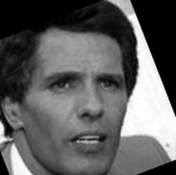

In [26]:
imagens_padronizadas, media_tamanho = padronizar_tamanho(imagens_padronizadas_olhos)
print(f"Média do tamanho das imagens: {media_tamanho[0]}x{media_tamanho[1]} pixels")

for i in range(len(imagens_padronizadas)):
    mostrar_imagem_array(imagens_padronizadas[i])

### 4. Salvando imagens
---
Segue ordem de execução aplicada a 5000 imagens.

#### 4.1 Detecta olhos e rotaciona

In [64]:
img_olhos = detectar_olhos(imagens)

In [65]:
img_rot = []
for img, res in zip(imagens, img_olhos):
    alinhada = alinhar_face(img, res)
    img_rot.append(alinhada)

In [ ]:
output_dir = r"C:\Users\Pedro\Code\pdi\parte1_imagens"

for img, img_name in zip(img_rot, image_files[:5000]):
    salvar_imagem(img, os.path.join(output_dir, img_name))

#### 4.2 Padroniza o tamanho dos olhos

In [66]:
img_olhos_padronizada, media = padronizar_distancia_olhos(img_rot, img_olhos)
print("Média das distâncias:", media)

Média das distâncias: 60.75337163185467


In [ ]:
output_dir = r"C:\Users\Pedro\Code\pdi\parte2_imagens"

for img, img_name in zip(img_olhos_padronizada, image_files[:5000]):
    salvar_imagem(img, os.path.join(output_dir, img_name))

#### 4.3 Padroniza o tamanho das imagens

In [67]:
img_padronizadas, tam = padronizar_tamanho(img_olhos_padronizada)
print("Tamanho padronizado:", tam)

Tamanho padronizado: (229, 249)


In [49]:
output_dir = r"C:\Users\Pedro\Code\pdi\parte3_imagens"

for img, img_name in zip(img_padronizadas, image_files[:5000]):
    salvar_imagem(img, os.path.join(output_dir, img_name))